<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/master/notebooks/HelloWorldTensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started with Tensorflow

The purpose of this notebook is to help new members of the Handwriting Lab
become more familiar with creating deep learning models in TensorFlow.
This is an opportunity for you to analyze the dataset, load the data, create
the model, and write the training loop.

In this notebook, we will use the popular *MNIST* dataset. *MNIST* is
a very simple dataset with the objective of classifying handwritten digits.
The data has been provided for you and (once downloaded) is located under the
`mnist_png` directory

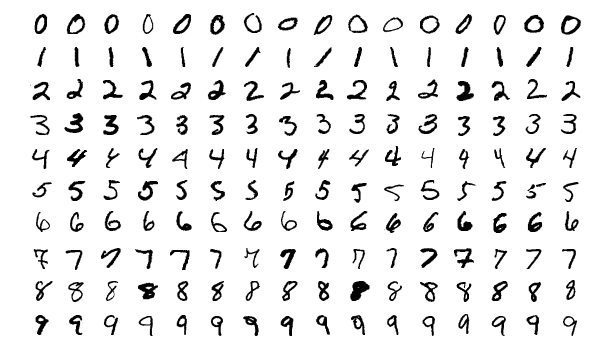

## Import TensorFlow and Other Dependencies

In [138]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

## Download the Dataset

Download the MNIST dataset from the BYU-Handwriting-Lab's Google Drive.

This may take a few minutes... 

In [ ]:
# DriveId: 1dBXw_kXpIsOf0jJc6htgrQ7XrZqriIQp
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dBXw_kXpIsOf0jJc6htgrQ7XrZqriIQp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1dBXw_kXpIsOf0jJc6htgrQ7XrZqriIQp" -O mnist.tar.gz && rm -rf /tmp/cookies.txt
!tar -xzf mnist.tar.gz
!rm mnist.tar.gz

Make sure everything downloaded correctly. We should see an `mnist_png` folder.

In [347]:
!ls  # We can run shell commands by prefixing them with '!'

mnist_png  sample_data


## Load the Data into TensorFlow using the tf.data API

Here, we specify the paths for the train and test dataset.

The `list_files` function searches through the specified path for files and
returns all file paths as tensor objects.

In [365]:
mnist_train_path = './mnist_png/training/*/*'
mnist_test_path = './mnist_png/testing/*/*'

train_dataset = tf.data.Dataset.list_files(mnist_train_path)
test_dataset = tf.data.Dataset.list_files(mnist_test_path)

We can take 5 instances from the dataset and iterate over them.

In [106]:
for path in train_dataset.take(5):
  print(path)

tf.Tensor(b'./mnist_png/training/0/30212.png', shape=(), dtype=string)
tf.Tensor(b'./mnist_png/training/1/47440.png', shape=(), dtype=string)
tf.Tensor(b'./mnist_png/training/9/7683.png', shape=(), dtype=string)
tf.Tensor(b'./mnist_png/training/8/56307.png', shape=(), dtype=string)
tf.Tensor(b'./mnist_png/training/0/29055.png', shape=(), dtype=string)


Let's see how many instances are in our training/testing sets.

In [107]:
print('Training Set Size: ', tf.data.experimental.cardinality(train_dataset).numpy())
print('Test Set Size: ', tf.data.experimental.cardinality(test_dataset).numpy())

Training Set Size:  60000
Test Set Size:  10000


Create a function that can map file paths to image/label pairs.

In [281]:
def path_to_image_label(path):
  """
  Convert a given file path to an image/label pair
  """
  parts = tf.strings.split(path, os.path.sep)

  raw_img = tf.io.read_file(path)
  png_img = tf.io.decode_png(raw_img)

  return tf.cast(png_img, dtype=tf.float32), tf.squeeze(tf.strings.to_number(parts[-2], out_type=tf.int32,))

Apply the above code using the `map` function and display the results.


Label:  1


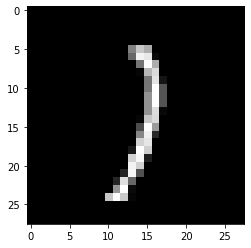

Label:  4


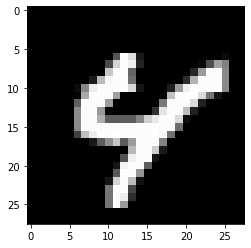

In [366]:
# Take 3 examples from the train dataset and map the file paths to an image/label pair
sample_dataset = train_dataset.take(2).map(path_to_image_label)

# Plot the image and print the label
for img, label in sample_dataset:
  print('Label: ', label.numpy())  # Display the label by converting the tensor to a numpy object
  plt.imshow(tf.squeeze(img), cmap='gray')  # Squeeze the image to 2-dimensions to allow for plotting
  plt.pause(.01)  # Pause to give time for plotting

## Build the Model

Here, we will build the Keras model that will make predictions on
handwritten digit images.

We can subclass the `tf.keras.Model` class and define the layers that will
make up our model.

In [367]:
class NeuralNetwork(tf.keras.Model):
  def __init__(self, num_classes=10):
    super(NeuralNetwork, self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(128, activation='relu')
    self.drop = tf.keras.layers.Dropout(0.2)
    self.dense2 = tf.keras.layers.Dense(num_classes)
    self.softmax = tf.keras.layers.Softmax()
  
  def call(self, x, **kwargs):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.drop(x)
    x = self.dense2(x)
    x = self.softmax(x)

    return x 

Test it out...

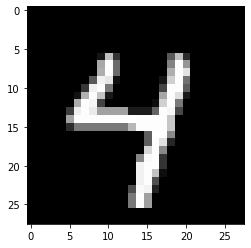

Loss: 12.96
Predicted Label: 7
Actual Label: 4


In [369]:
dataset = tf.data.Dataset.list_files('./mnist_png/training/*/*').take(1).map(path_to_image_label).batch(1)
model = NeuralNetwork()

for image, label in dataset:
  plt.imshow(tf.squeeze(image[0]), cmap='gray')
  plt.pause(.01)

  out = model(image)
  preds = tf.argmax(out, axis=1)

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(label, out).numpy()
  
  print('Loss: {:.2f}'.format(loss))
  print('Predicted Label:', preds.numpy()[0])
  print('Actual Label:', label.numpy()[0])

## Write the Training Loop

In [370]:
@tf.function
def train_step(image, label):
  with tf.GradientTape() as tape:
    preds = model(image, training=True)
    loss = loss_fn(label, preds)
  
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_acc(label, tf.argmax(preds, axis=1))

@tf.function
def val_step(image, label):
  preds = model(image, training=False)
  loss = loss_fn(label, preds)

  val_loss(loss)
  val_acc(label, tf.argmax(preds, axis=1))


train_epochs = 5
batch_size = 128

train_dataset = tf.data.Dataset.list_files('./mnist_png/training/*/*', shuffle=True)\
                               .shuffle(200, reshuffle_each_iteration=True)\
                               .map(path_to_image_label)\
                               .batch(batch_size)
test_dataset = tf.data.Dataset.list_files('./mnist_png/testing/*/*')\
                              .map(path_to_image_label)\
                              .batch(batch_size)

train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
test_dataset_size = tf.data.experimental.cardinality(test_dataset).numpy()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model = NeuralNetwork()

# Create our metrics to keep track of our progress during
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.Accuracy(name='train_acc')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_acc = tf.keras.metrics.Accuracy(name='val_acc')

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(train_epochs):
  train_loss.reset_states()
  train_acc.reset_states()
  val_loss.reset_states()
  val_acc.reset_states()

  # Train Loop
  train_loop = tqdm(total=train_dataset_size, position=0, leave=True)
  for image, label in train_dataset:
    train_step(image, label)
    train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch, train_loss.result(), train_acc.result()))
    train_loop.update(1)
  train_loop.close()

  # Validation Loop
  val_loop = tqdm(total=test_dataset_size, position=0, leave=True)
  for image, label in test_dataset:
    val_step(image, label)
    val_loop.set_description('Val   - Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch, val_loss.result(), val_acc.result()))
    val_loop.update(1)
  val_loop.close()

  train_losses.append(train_loss.result())
  val_losses.append(val_loss.result())
  train_accs.append(train_acc.result())
  val_accs.append(val_acc.result())

Val   - Epoch: 4, Loss: 0.1114, Accuracy: 0.9752: 100%|██████████| 79/79 [00:04<00:00, 16.59it/s]


### Display the Loss/Accuracy Graphs During Training

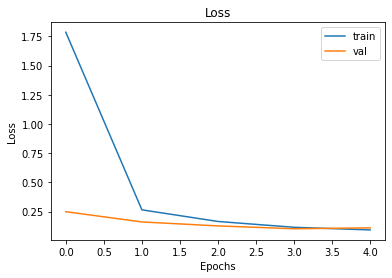

Final Validation Loss: 0.1114


In [371]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()
print('Final Validation Loss: {:.4f}'.format(val_losses[-1]))

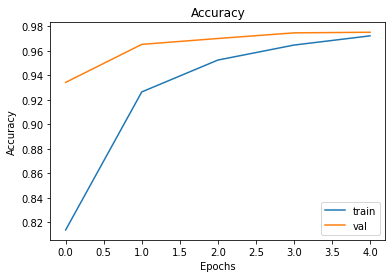

Final Validation Accuracy: 0.98


In [372]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='val')
plt.legend()
plt.show()
print('Final Validation Accuracy: {:.2f}'.format(val_accs[-1]))

## Results/Examples

Now that we've trained our model, let's see some concrete examples on how it's
doing.

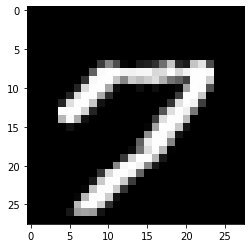

Predicted Label: 7
Actual Label: 7


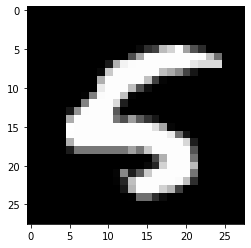

Predicted Label: 5
Actual Label: 5


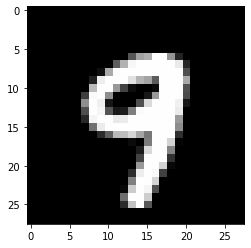

Predicted Label: 9
Actual Label: 9


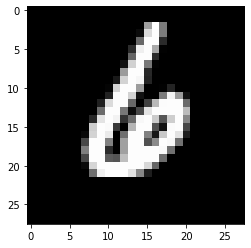

Predicted Label: 6
Actual Label: 6


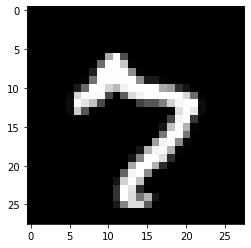

Predicted Label: 7
Actual Label: 7


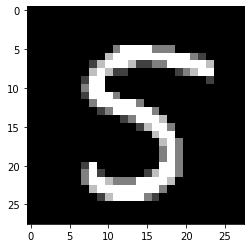

Predicted Label: 5
Actual Label: 5


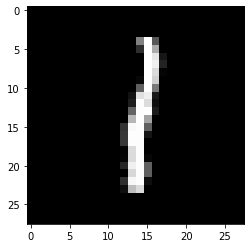

Predicted Label: 1
Actual Label: 1


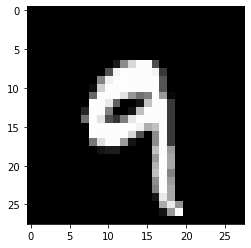

Predicted Label: 9
Actual Label: 9


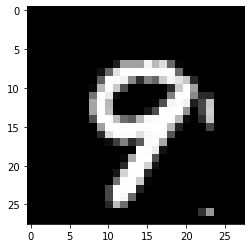

Predicted Label: 9
Actual Label: 9


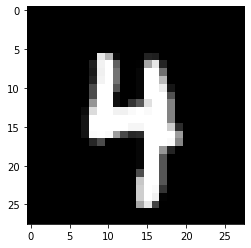

Predicted Label: 4
Actual Label: 4


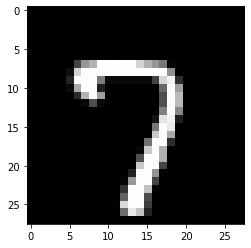

Predicted Label: 7
Actual Label: 7


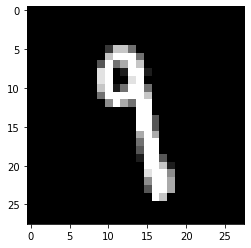

Predicted Label: 1
Actual Label: 9


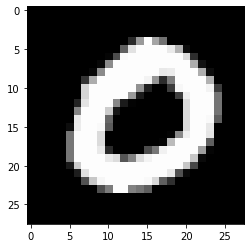

Predicted Label: 0
Actual Label: 0


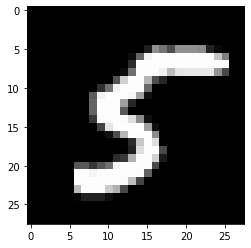

Predicted Label: 5
Actual Label: 5


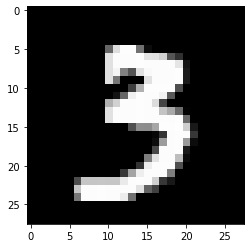

Predicted Label: 3
Actual Label: 3


In [373]:
dataset = tf.data.Dataset.list_files('./mnist_png/testing/*/*').take(15).map(path_to_image_label).batch(1)

for image, label in dataset:
  pred = model(image)
  pred = tf.argmax(pred, axis=1)

  plt.imshow(tf.squeeze(image), cmap='gray')
  plt.pause(.01)
  print('Predicted Label:', pred.numpy()[0])
  print('Actual Label:', label.numpy()[0])
